In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random

# exploring the data

In [57]:
df = pd.read_csv("age_gender.csv") 

In [58]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [60]:
df['ethnicity'].value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64

In [61]:
df['age'].value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Name: age, Length: 104, dtype: int64

In [62]:
df["gender"].value_counts()

0    12391
1    11314
Name: gender, dtype: int64

In [63]:
df.describe()

,age,ethnicity,gender
count,23705.000000,23705.000000,23705.000000
mean,33.300907,1.269226,0.477283
std,19.885708,1.345638,0.499494
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,1.000000,0.000000
75%,45.000000,2.000000,1.000000
max,116.000000,4.000000,1.000000


In [64]:
def plot_images(df, num_of_imgs):
    if num_of_imgs % 5 != 0:
        raise Exception("num_of_imgs has to be a number divisible by 5")
    data = np.empty([num_of_imgs, 48*48])
    gender = np.empty([num_of_imgs,1])
    ethnicity = np.empty([num_of_imgs,1])
    age = np.empty([num_of_imgs,1])
    for i in range(num_of_imgs):
        idx = random.randint(0, len(df)-1)
        array = np.array(df.iloc[idx,4].split(), 'float64')
        data[i] = array
        gender[i] = df["gender"][idx]
        ethnicity[i] = df["ethnicity"][idx]
        age[i] = df["age"][idx]
    n_rows = num_of_imgs//5
    n_cols = 5
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index].reshape(48,48))
            plt.axis('off')
            plt.title("gender = {}\n, ethnicity = {}\n, age = {}".format(gender[index], ethnicity[index], age[index]), 
                      fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

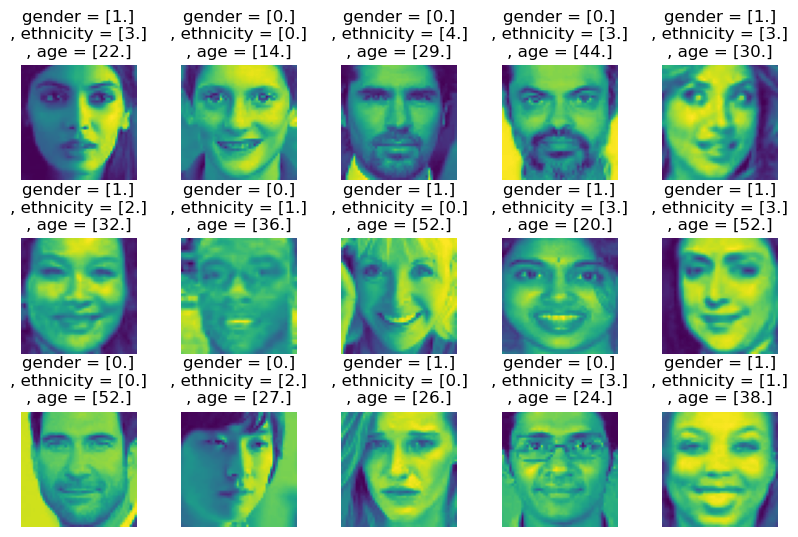

In [65]:
plot_images(df, 15)

# prepraing the data

In [66]:
def prepare_images(df):
    i = len(df)
    data = np.empty([i, 48,48,1])
    for j in range(i):
        array = np.array(df.iloc[j,4].split(), 'float64')
        data[j] = array.reshape(48,48,1)
    return data

In [67]:
X = prepare_images(df)
X = X/255.0
y = np.array(df[["ethnicity","gender", "age"]])

In [68]:
testsize = (10 * len(df))//100
validation_split = 0.1

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=42)

In [70]:
y_train_ethnicity, y_train_gender, y_train_age = y_train[:,0], y_train[:,1], y_train[:,2]
y_test_ethnicity, y_test_gender, y_test_age = y_test[:,0], y_test[:,1], y_test[:,2]

# creating the model

In [16]:
Input = keras.layers.Input(shape=(48,48,1))
l = keras.layers.Conv2D(64, 7, activation="relu", padding="same")(Input)
l = keras.layers.MaxPooling2D(2)(l)
l = keras.layers.Conv2D(128, 3, activation="relu", padding="same")(l)
l = keras.layers.Conv2D(128, 3, activation="relu", padding="same")(l)
l = keras.layers.MaxPooling2D(2)(l)
l = keras.layers.Conv2D(256, 3, activation="relu", padding="same")(l)
l = keras.layers.Conv2D(256, 3, activation="relu", padding="same")(l)
l = keras.layers.MaxPooling2D(2)(l)
l = keras.layers.Flatten()(l)
l = keras.layers.Dense(128, activation="relu")(l)
l = keras.layers.Dropout(0.5)(l)
l = keras.layers.Dense(64, activation="relu")(l)
age_output = keras.layers.Dense(1, name = "age_output")(l)
ethnicity_output = keras.layers.Dense(5, activation="softmax", name = "ethnicity_output")(l)
gender_output = keras.layers.Dense(1, activation="sigmoid", name = "gender_output")(l)
model = keras.Model(inputs=[Input], outputs=[ethnicity_output, gender_output, age_output])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 24, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

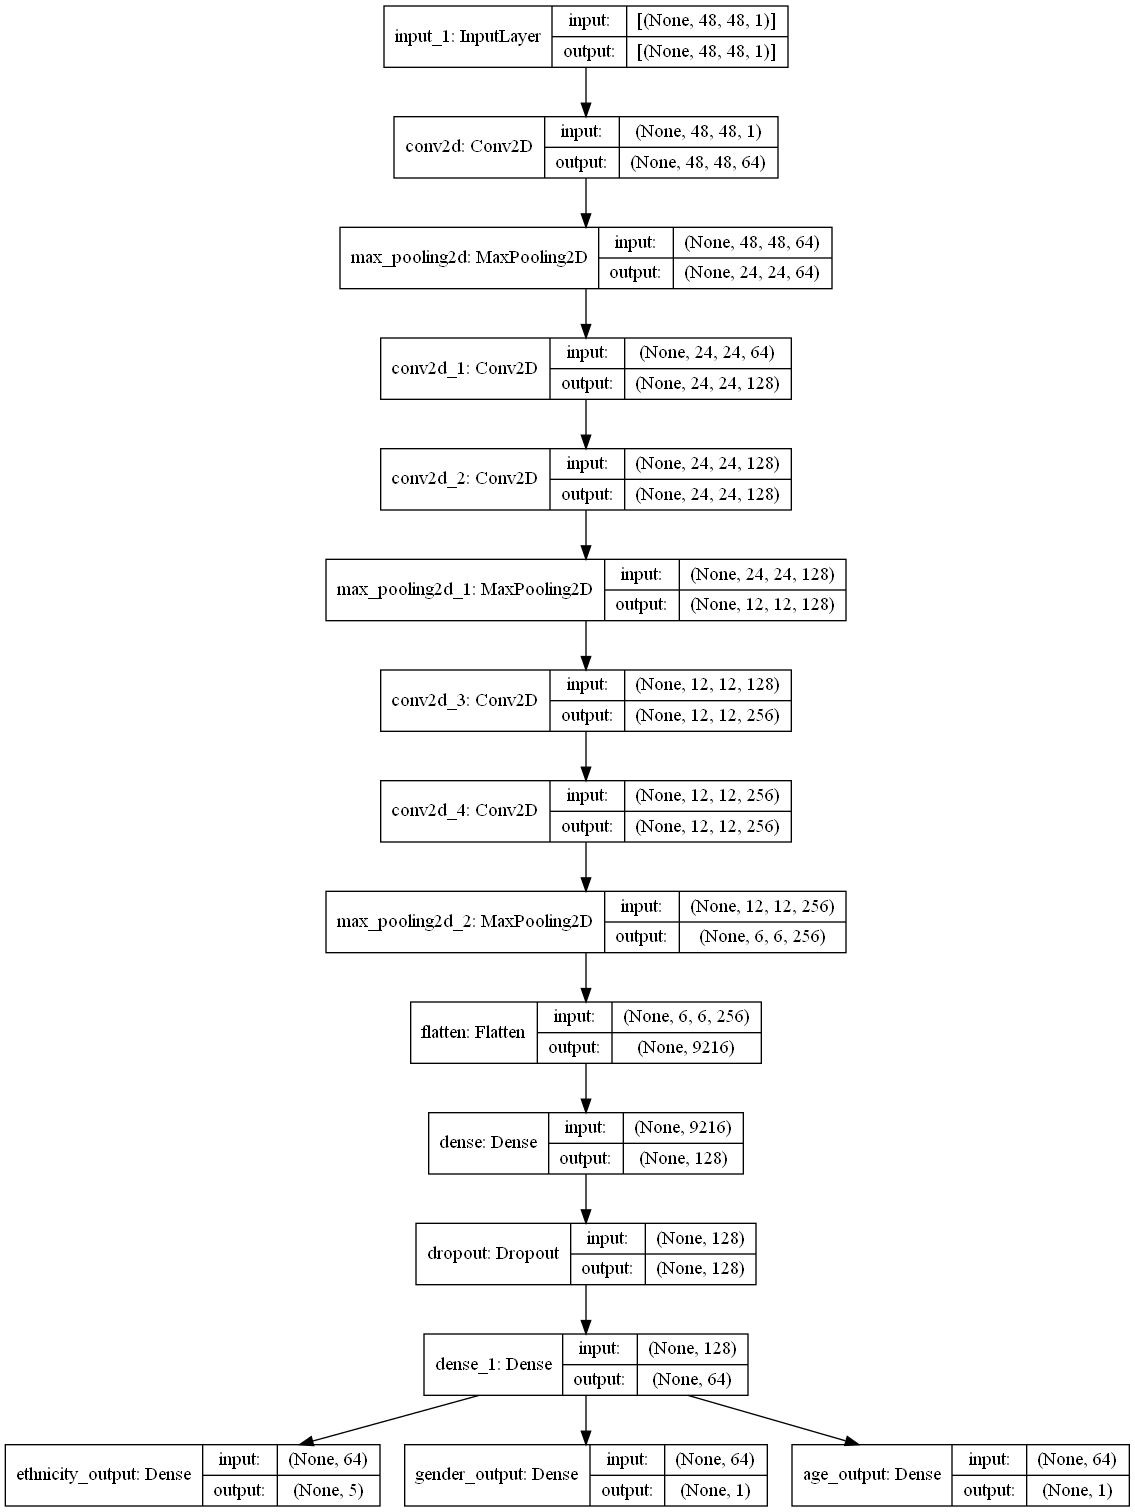

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
model.compile(loss=["sparse_categorical_crossentropy", "binary_crossentropy", "mse"], 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=["accuracy"])
ROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

In [20]:
history = model.fit(
[X_train], [y_train_ethnicity, y_train_gender, y_train_age], epochs=20,
validation_split=validation_split,
callbacks = [ROP])

Epoch 1/20
601/601 [==============================] - 274s 453ms/step - loss: 468.4820 - ethnicity_output_loss: 3.0500 - gender_output_loss: 1.2684 - age_output_loss: 464.1631 - ethnicity_output_accuracy: 0.2808 - gender_output_accuracy: 0.5047 - age_output_accuracy: 0.0477 - val_loss: 580.6263 - val_ethnicity_output_loss: 1.5600 - val_gender_output_loss: 0.6995 - val_age_output_loss: 578.3670 - val_ethnicity_output_accuracy: 0.4152 - val_gender_output_accuracy: 0.5225 - val_age_output_accuracy: 0.0473
Epoch 2/20
601/601 [==============================] - 238s 396ms/step - loss: 307.2938 - ethnicity_output_loss: 1.7143 - gender_output_loss: 0.7457 - age_output_loss: 304.8337 - ethnicity_output_accuracy: 0.3393 - gender_output_accuracy: 0.5153 - age_output_accuracy: 0.0478 - val_loss: 486.2246 - val_ethnicity_output_loss: 1.4778 - val_gender_output_loss: 0.6721 - val_age_output_loss: 484.0748 - val_ethnicity_output_accuracy: 0.3496 - val_gender_output_accuracy: 0.6181 - val_age_output_a

601/601 [==============================] - 209s 347ms/step - loss: 74.7625 - ethnicity_output_loss: 1.3963 - gender_output_loss: 0.6783 - age_output_loss: 72.6879 - ethnicity_output_accuracy: 0.4259 - gender_output_accuracy: 0.5778 - age_output_accuracy: 0.0478 - val_loss: 372.6650 - val_ethnicity_output_loss: 1.4290 - val_gender_output_loss: 0.6807 - val_age_output_loss: 370.5553 - val_ethnicity_output_accuracy: 0.4114 - val_gender_output_accuracy: 0.5956 - val_age_output_accuracy: 0.0473
Epoch 18/20
601/601 [==============================] - 204s 339ms/step - loss: 73.4747 - ethnicity_output_loss: 1.3946 - gender_output_loss: 0.6753 - age_output_loss: 71.4049 - ethnicity_output_accuracy: 0.4255 - gender_output_accuracy: 0.5851 - age_output_accuracy: 0.0478 - val_loss: 366.7496 - val_ethnicity_output_loss: 1.4305 - val_gender_output_loss: 0.6796 - val_age_output_loss: 364.6395 - val_ethnicity_output_accuracy: 0.4114 - val_gender_output_accuracy: 0.6068 - val_age_output_accuracy: 0.047

In [22]:
model.save("age,gender,ethnicity model")

INFO:tensorflow:Assets written to: age,gender,ethnicity model\assets


second smaller model

In [30]:
Input_sss = keras.layers.Input(shape=(48,48,1))
l_sss = keras.layers.Conv2D(32, 3, activation="relu")(Input_sss)
l_sss = keras.layers.BatchNormalization()(l_sss)
l_sss = keras.layers.MaxPooling2D(2)(l_sss)
l_sss = keras.layers.Conv2D(64, 3, activation="relu")(l_sss)
l_sss = keras.layers.BatchNormalization()(l_sss)
l_sss = keras.layers.MaxPooling2D(2)(l_sss)
l_sss = keras.layers.Conv2D(128, 3, activation="relu")(l_sss)
l_sss = keras.layers.BatchNormalization()(l_sss)
l_sss = keras.layers.MaxPooling2D(2)(l_sss)
l_sss = keras.layers.Flatten()(l_sss)

ethnicity_sss = keras.layers.Dense(128, activation="relu")(l_sss)
ethnicity_sss = keras.layers.Dropout(rate=0.5)(ethnicity_sss)
ethnicity_sss = keras.layers.Dense(128, activation="relu")(ethnicity_sss)
ethnicity_sss = keras.layers.Dropout(rate=0.5)(ethnicity_sss)
ethnicity_output_sss = keras.layers.Dense(5, activation="softmax", name = "ethnicity_output_sss")(ethnicity_sss)

gender_sss = keras.layers.Dense(128, activation="relu")(l_sss)
gender_sss = keras.layers.Dropout(rate=0.5)(gender_sss)
gender_sss = keras.layers.Dense(128, activation="relu")(gender_sss)
gender_sss = keras.layers.Dropout(rate=0.5)(gender_sss)
gender_output_sss = keras.layers.Dense(1, activation="sigmoid", name = "gender_output_sss")(gender_sss)

age_sss = keras.layers.Dense(128, activation="relu")(l_sss)
age_sss = keras.layers.Dropout(rate=0.5)(age_sss)
age_sss = keras.layers.Dense(128, activation="relu")(age_sss)
age_sss = keras.layers.Dropout(rate=0.5)(age_sss)
age_output_sss = keras.layers.Dense(1, name = "age_output_sss")(age_sss)


model_sss = keras.Model(inputs=[Input_sss], outputs=[ethnicity_output_sss, gender_output_sss, age_output_sss])

In [31]:
model_sss.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 46, 46, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 46, 46, 32)   128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 23, 23, 32)   0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

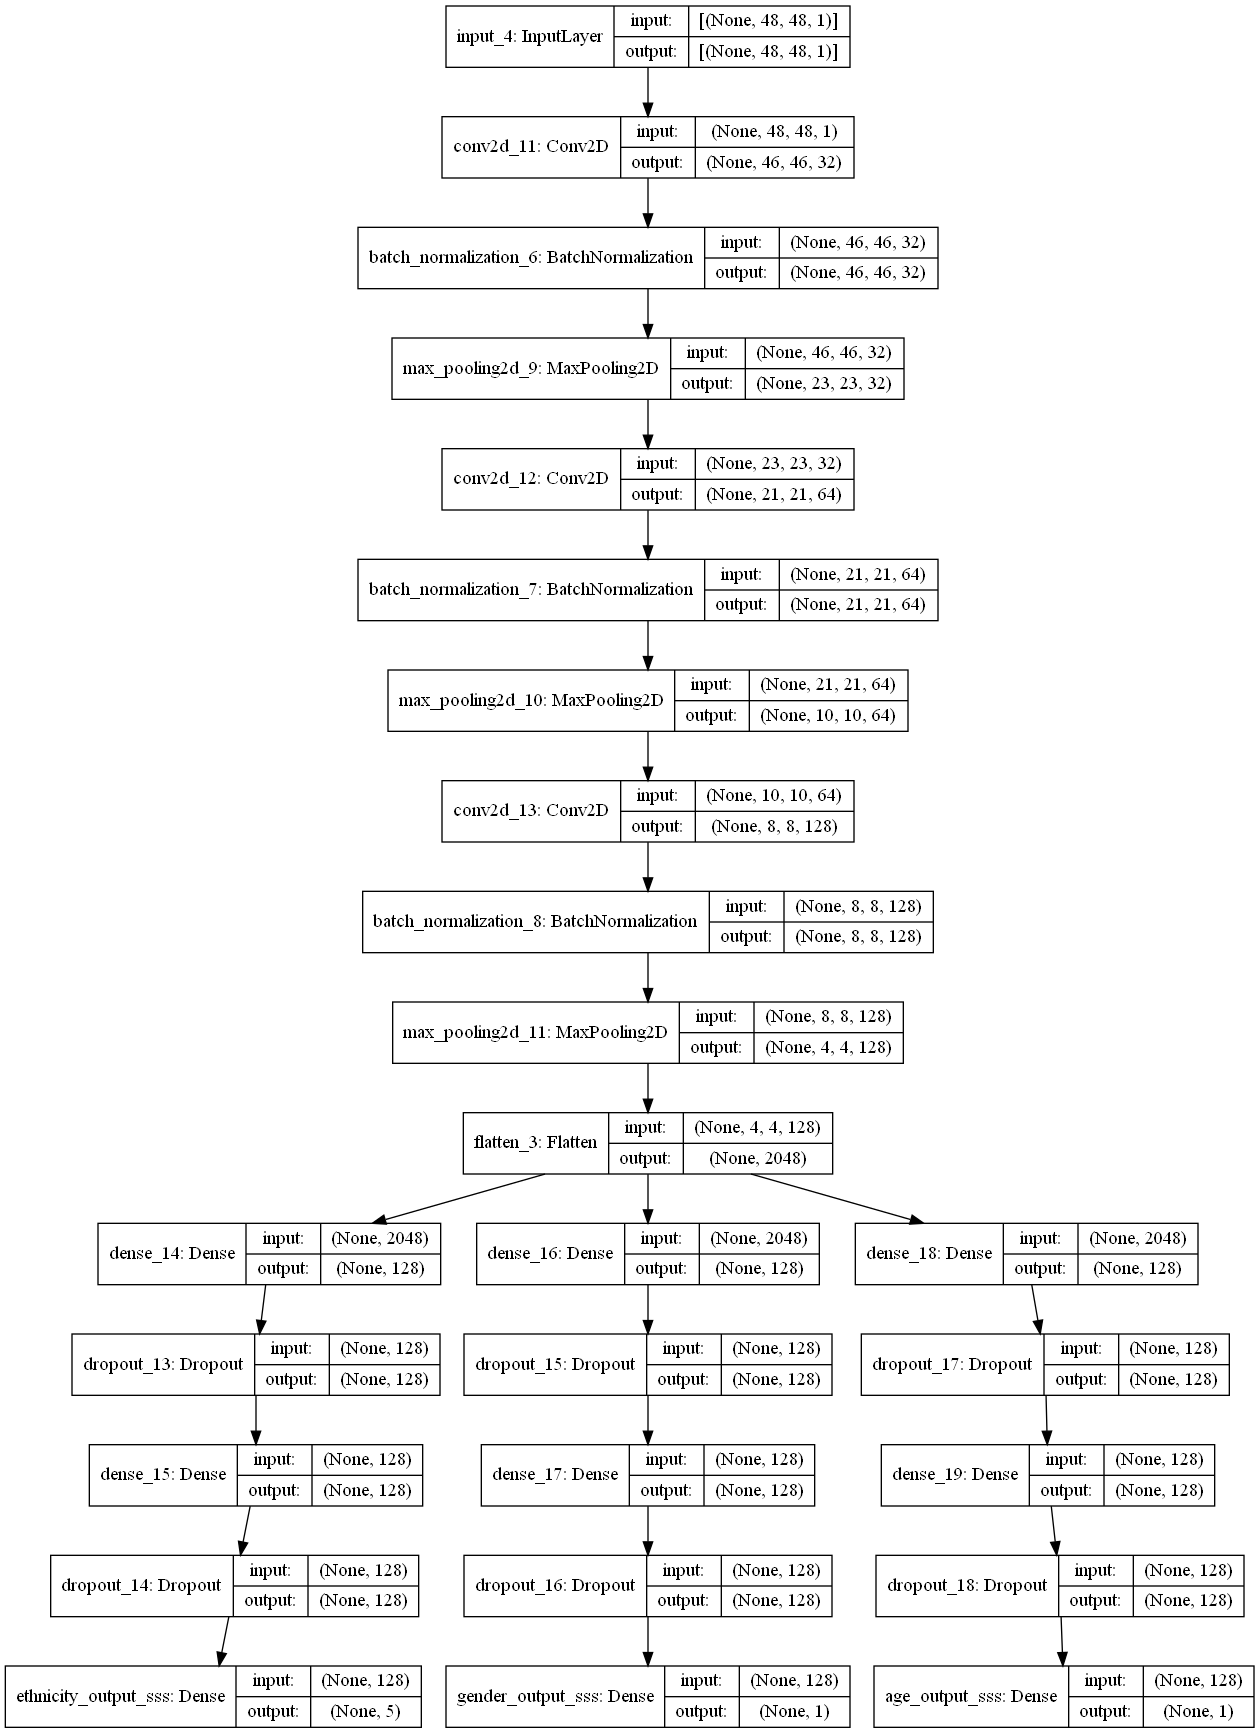

In [32]:
plot_model(model_sss, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="age_gender model_sss",
                                                               monitor = "val_loss",
                                                               save_best_only = True)

def scheduler(epoch, lr):
    if epoch % 20 == 0:
        return lr * 0.1
    else:
        return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [34]:
model_sss.compile(loss=["sparse_categorical_crossentropy", "binary_crossentropy", "mse"], 
              optimizer=keras.optimizers.Adam(learning_rate=0.005), 
              metrics=["accuracy"])

mean = y_train_age.mean(axis = 0)
std = y_train_age.std(axis = 0)
y_train_age_centered = (y_train_age - mean)/std

history_sss = model_sss.fit(X_train, 
                          [y_train_ethnicity, y_train_gender, y_train_age_centered], 
                          epochs=80,
                          callbacks = [model_checkpoint_callback, callback],
                          validation_split=validation_split)

Epoch 1/80
601/601 [==============================] - 51s 82ms/step - loss: 2.9526 - ethnicity_output_sss_loss: 1.3589 - gender_output_sss_loss: 0.5524 - age_output_sss_loss: 1.0413 - ethnicity_output_sss_accuracy: 0.4751 - gender_output_sss_accuracy: 0.7312 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 2.0835 - val_ethnicity_output_sss_loss: 1.0858 - val_gender_output_sss_loss: 0.3754 - val_age_output_sss_loss: 0.6223 - val_ethnicity_output_sss_accuracy: 0.5909 - val_gender_output_sss_accuracy: 0.8351 - val_age_output_sss_accuracy: 0.0000e+00
INFO:tensorflow:Assets written to: age_gender model_sss\assets
Epoch 2/80
601/601 [==============================] - 49s 81ms/step - loss: 2.1246 - ethnicity_output_sss_loss: 1.0998 - gender_output_sss_loss: 0.3952 - age_output_sss_loss: 0.6296 - ethnicity_output_sss_accuracy: 0.5856 - gender_output_sss_accuracy: 0.8185 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 1.8740 - val_ethnicity_output_sss_loss: 0.9366 - val_gender_output_sss_los

Epoch 15/80
601/601 [==============================] - 37s 62ms/step - loss: 0.8409 - ethnicity_output_sss_loss: 0.4457 - gender_output_sss_loss: 0.1508 - age_output_sss_loss: 0.2444 - ethnicity_output_sss_accuracy: 0.8445 - gender_output_sss_accuracy: 0.9347 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 1.3370 - val_ethnicity_output_sss_loss: 0.6685 - val_gender_output_sss_loss: 0.2731 - val_age_output_sss_loss: 0.3955 - val_ethnicity_output_sss_accuracy: 0.7774 - val_gender_output_sss_accuracy: 0.8983 - val_age_output_sss_accuracy: 0.0000e+00
INFO:tensorflow:Assets written to: age_gender model_sss\assets
Epoch 16/80
601/601 [==============================] - 38s 63ms/step - loss: 0.7969 - ethnicity_output_sss_loss: 0.4314 - gender_output_sss_loss: 0.1413 - age_output_sss_loss: 0.2242 - ethnicity_output_sss_accuracy: 0.8479 - gender_output_sss_accuracy: 0.9413 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 1.6160 - val_ethnicity_output_sss_loss: 0.7843 - val_gender_output_sss_l

Epoch 30/80
601/601 [==============================] - 40s 67ms/step - loss: 0.4009 - ethnicity_output_sss_loss: 0.1916 - gender_output_sss_loss: 0.0473 - age_output_sss_loss: 0.1620 - ethnicity_output_sss_accuracy: 0.9294 - gender_output_sss_accuracy: 0.9779 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 1.8967 - val_ethnicity_output_sss_loss: 1.0200 - val_gender_output_sss_loss: 0.5124 - val_age_output_sss_loss: 0.3643 - val_ethnicity_output_sss_accuracy: 0.7933 - val_gender_output_sss_accuracy: 0.8927 - val_age_output_sss_accuracy: 0.0000e+00.0475 - age_output_sss
Epoch 31/80
601/601 [==============================] - 40s 67ms/step - loss: 0.3896 - ethnicity_output_sss_loss: 0.1858 - gender_output_sss_loss: 0.0435 - age_output_sss_loss: 0.1603 - ethnicity_output_sss_accuracy: 0.9332 - gender_output_sss_accuracy: 0.9799 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 1.9006 - val_ethnicity_output_sss_loss: 0.9848 - val_gender_output_sss_loss: 0.5237 - val_age_output_sss_loss: 0.

601/601 [==============================] - 41s 68ms/step - loss: 0.3157 - ethnicity_output_sss_loss: 0.1397 - gender_output_sss_loss: 0.0285 - age_output_sss_loss: 0.1475 - ethnicity_output_sss_accuracy: 0.9518 - gender_output_sss_accuracy: 0.9868 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 2.5032 - val_ethnicity_output_sss_loss: 1.3325 - val_gender_output_sss_loss: 0.7894 - val_age_output_sss_loss: 0.3812 - val_ethnicity_output_sss_accuracy: 0.7924 - val_gender_output_sss_accuracy: 0.8936 - val_age_output_sss_accuracy: 0.0000e+00
Epoch 45/80
601/601 [==============================] - 43s 71ms/step - loss: 0.3138 - ethnicity_output_sss_loss: 0.1362 - gender_output_sss_loss: 0.0286 - age_output_sss_loss: 0.1490 - ethnicity_output_sss_accuracy: 0.9529 - gender_output_sss_accuracy: 0.9868 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 2.5330 - val_ethnicity_output_sss_loss: 1.3495 - val_gender_output_sss_loss: 0.8014 - val_age_output_sss_loss: 0.3820 - val_ethnicity_output_sss_ac

Epoch 59/80
601/601 [==============================] - 42s 70ms/step - loss: 0.3107 - ethnicity_output_sss_loss: 0.1333 - gender_output_sss_loss: 0.0284 - age_output_sss_loss: 0.1489 - ethnicity_output_sss_accuracy: 0.9548 - gender_output_sss_accuracy: 0.9867 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 2.6605 - val_ethnicity_output_sss_loss: 1.4164 - val_gender_output_sss_loss: 0.8566 - val_age_output_sss_loss: 0.3876 - val_ethnicity_output_sss_accuracy: 0.7952 - val_gender_output_sss_accuracy: 0.8927 - val_age_output_sss_accuracy: 0.0000e+00
Epoch 60/80
601/601 [==============================] - 42s 70ms/step - loss: 0.3078 - ethnicity_output_sss_loss: 0.1380 - gender_output_sss_loss: 0.0278 - age_output_sss_loss: 0.1420 - ethnicity_output_sss_accuracy: 0.9537 - gender_output_sss_accuracy: 0.9866 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 2.6535 - val_ethnicity_output_sss_loss: 1.4121 - val_gender_output_sss_loss: 0.8556 - val_age_output_sss_loss: 0.3858 - val_ethnicity_o

601/601 [==============================] - 41s 68ms/step - loss: 0.3025 - ethnicity_output_sss_loss: 0.1328 - gender_output_sss_loss: 0.0249 - age_output_sss_loss: 0.1448 - ethnicity_output_sss_accuracy: 0.9540 - gender_output_sss_accuracy: 0.9885 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 2.6910 - val_ethnicity_output_sss_loss: 1.4440 - val_gender_output_sss_loss: 0.8616 - val_age_output_sss_loss: 0.3854 - val_ethnicity_output_sss_accuracy: 0.7924 - val_gender_output_sss_accuracy: 0.8932 - val_age_output_sss_accuracy: 0.0000e+00
Epoch 74/80
601/601 [==============================] - 41s 68ms/step - loss: 0.3057 - ethnicity_output_sss_loss: 0.1352 - gender_output_sss_loss: 0.0268 - age_output_sss_loss: 0.1438 - ethnicity_output_sss_accuracy: 0.9548 - gender_output_sss_accuracy: 0.9878 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 2.6859 - val_ethnicity_output_sss_loss: 1.4386 - val_gender_output_sss_loss: 0.8622 - val_age_output_sss_loss: 0.3851 - val_ethnicity_output_sss_ac

In [42]:
def build_model(learning_rate, dropout_rate):
    Input_sss = keras.layers.Input(shape=(48,48,1))
    l_sss = keras.layers.Conv2D(32, 3, activation="relu")(Input_sss)
    l_sss = keras.layers.BatchNormalization()(l_sss)
    l_sss = keras.layers.MaxPooling2D(2)(l_sss)
    l_sss = keras.layers.Conv2D(64, 3, activation="relu")(l_sss)
    l_sss = keras.layers.BatchNormalization()(l_sss)
    l_sss = keras.layers.MaxPooling2D(2)(l_sss)
    l_sss = keras.layers.Conv2D(128, 3, activation="relu")(l_sss)
    l_sss = keras.layers.BatchNormalization()(l_sss)
    l_sss = keras.layers.MaxPooling2D(2)(l_sss)
    l_sss = keras.layers.Flatten()(l_sss)

    ethnicity_sss = keras.layers.Dense(128, activation="relu")(l_sss)
    ethnicity_sss = keras.layers.Dropout(rate=dropout_rate)(ethnicity_sss)
    ethnicity_sss = keras.layers.Dense(128, activation="relu")(ethnicity_sss)
    ethnicity_sss = keras.layers.Dropout(rate=dropout_rate)(ethnicity_sss)
    ethnicity_output_sss = keras.layers.Dense(5, activation="softmax", name = "ethnicity_output_sss")(ethnicity_sss)

    gender_sss = keras.layers.Dense(128, activation="relu")(l_sss)
    gender_sss = keras.layers.Dropout(rate=dropout_rate)(gender_sss)
    gender_sss = keras.layers.Dense(128, activation="relu")(gender_sss)
    gender_sss = keras.layers.Dropout(rate=dropout_rate)(gender_sss)
    gender_output_sss = keras.layers.Dense(1, activation="sigmoid", name = "gender_output_sss")(gender_sss)

    age_sss = keras.layers.Dense(128, activation="relu")(l_sss)
    age_sss = keras.layers.Dropout(rate=dropout_rate)(age_sss)
    age_sss = keras.layers.Dense(128, activation="relu")(age_sss)
    age_sss = keras.layers.Dropout(rate=dropout_rate)(age_sss)
    age_output_sss = keras.layers.Dense(1, name = "age_output_sss")(age_sss)


    model_sss = keras.Model(inputs=[Input_sss], outputs=[ethnicity_output_sss, gender_output_sss, age_output_sss])
    
    model_sss.compile(loss=["sparse_categorical_crossentropy", "binary_crossentropy", "mse"], 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              metrics=["accuracy"])
    return model_sss

In [78]:
model_3 = build_model(0.001, 0.5)

In [79]:
history_3 = model_3.fit(X_train, 
                          [y_train_ethnicity, y_train_gender, y_train_age_centered], 
                          epochs=25,
                          validation_split=validation_split)

Epoch 1/25
601/601 [==============================] - 37s 60ms/step - loss: 2.9210 - ethnicity_output_sss_loss: 1.3528 - gender_output_sss_loss: 0.5232 - age_output_sss_loss: 1.0450 - ethnicity_output_sss_accuracy: 0.4821 - gender_output_sss_accuracy: 0.7408 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 2.1680 - val_ethnicity_output_sss_loss: 1.0431 - val_gender_output_sss_loss: 0.3874 - val_age_output_sss_loss: 0.7374 - val_ethnicity_output_sss_accuracy: 0.6012 - val_gender_output_sss_accuracy: 0.8163 - val_age_output_sss_accuracy: 0.0000e+00
Epoch 2/25
601/601 [==============================] - 36s 60ms/step - loss: 2.1001 - ethnicity_output_sss_loss: 1.0951 - gender_output_sss_loss: 0.3754 - age_output_sss_loss: 0.6297 - ethnicity_output_sss_accuracy: 0.5816 - gender_output_sss_accuracy: 0.8267 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 1.9091 - val_ethnicity_output_sss_loss: 0.9754 - val_gender_output_sss_loss: 0.3195 - val_age_output_sss_loss: 0.6143 - val_ethnicity_out

Epoch 16/25
601/601 [==============================] - 40s 67ms/step - loss: 0.8985 - ethnicity_output_sss_loss: 0.5169 - gender_output_sss_loss: 0.1506 - age_output_sss_loss: 0.2311 - ethnicity_output_sss_accuracy: 0.8354 - gender_output_sss_accuracy: 0.9330 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 1.8748 - val_ethnicity_output_sss_loss: 0.7858 - val_gender_output_sss_loss: 0.3423 - val_age_output_sss_loss: 0.7467 - val_ethnicity_output_sss_accuracy: 0.7273 - val_gender_output_sss_accuracy: 0.8758 - val_age_output_sss_accuracy: 0.0000e+00
Epoch 17/25
601/601 [==============================] - 41s 68ms/step - loss: 0.8546 - ethnicity_output_sss_loss: 0.4876 - gender_output_sss_loss: 0.1431 - age_output_sss_loss: 0.2238 - ethnicity_output_sss_accuracy: 0.8425 - gender_output_sss_accuracy: 0.9402 - age_output_sss_accuracy: 0.0000e+00 - val_loss: 1.5294 - val_ethnicity_output_sss_loss: 0.7162 - val_gender_output_sss_loss: 0.3490 - val_age_output_sss_loss: 0.4642 - val_ethnicity_o

In [90]:
model_3.save("age,gender,ethnicity model")

INFO:tensorflow:Assets written to: age,gender,ethnicity model\assets


In [82]:
best_saved_model = keras.models.load_model("age_gender model_sss")

# evaluating the models

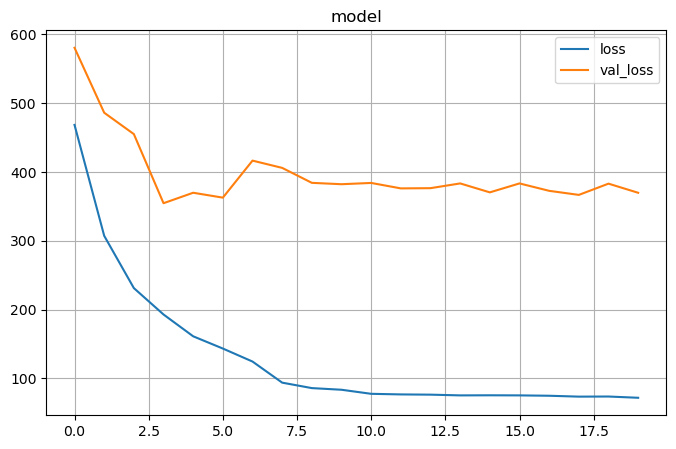

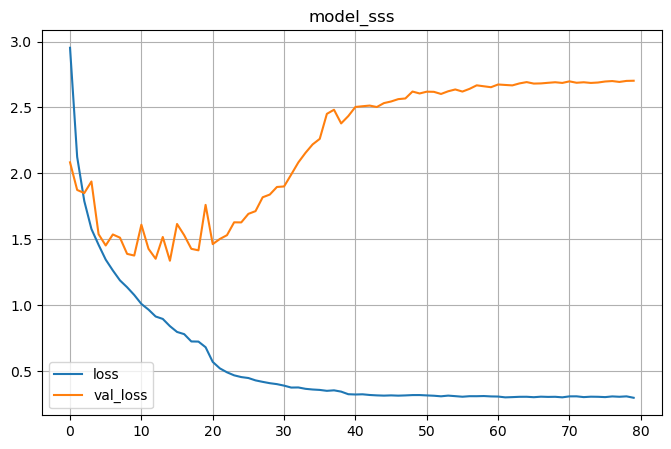

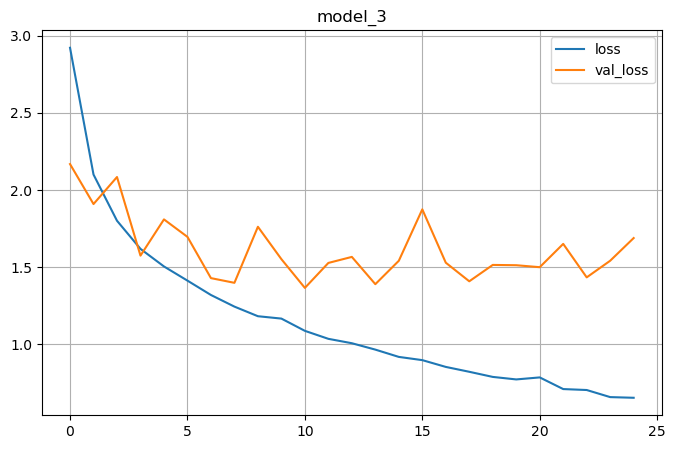

In [94]:
pd.DataFrame(history.history)[["loss", 'val_loss']].plot(figsize=(8,5), title = "model")
plt.grid(True)
plt.show()
pd.DataFrame(history_sss.history)[["loss", 'val_loss']].plot(figsize=(8,5), title = "model_sss")
plt.grid(True)
plt.show()
pd.DataFrame(history_3.history)[["loss", 'val_loss']].plot(figsize=(8,5), title = "model_3")
plt.grid(True)
plt.show()

In [98]:
model_eval = model.evaluate(X_test,[y_test_ethnicity, y_test_gender, y_test_age])
print("\nethnicity_output_accuracy = ", model_eval[4])
print("gender_output_accuracy = ", model_eval[5])
print("age_output_loss = ", model_eval[3])

75/75 [==============================] - 6s 79ms/step - loss: 350.7590 - ethnicity_output_loss: 1.4265 - gender_output_loss: 0.6803 - age_output_loss: 348.6523 - ethnicity_output_accuracy: 0.4105 - gender_output_accuracy: 0.5962 - age_output_accuracy: 0.0439
ethnicity_output_accuracy =  0.41054853796958923
gender_output_accuracy =  0.596202552318573
age_output_loss =  348.65228271484375


In [102]:
model_eval = model_sss.evaluate(X_test,[y_test_ethnicity, y_test_gender, (y_test_age- mean)/std])
print("\nethnicity_output_accuracy = ", model_eval[4])
print("gender_output_accuracy = ", model_eval[5])
print("age_output_loss = ", model_eval[3])

75/75 [==============================] - 1s 13ms/step - loss: 2.4369 - ethnicity_output_sss_loss: 1.3364 - gender_output_sss_loss: 0.7327 - age_output_sss_loss: 0.3678 - ethnicity_output_sss_accuracy: 0.7873 - gender_output_sss_accuracy: 0.9089 - age_output_sss_accuracy: 0.0000e+00

ethnicity_output_accuracy =  0.7873417735099792
gender_output_accuracy =  0.9088607430458069
age_output_loss =  0.36784520745277405


In [103]:
model_eval = model_3.evaluate(X_test,[y_test_ethnicity, y_test_gender, (y_test_age- mean)/std])
print("\nethnicity_output_accuracy = ", model_eval[4])
print("gender_output_accuracy = ", model_eval[5])
print("age_output_loss = ", model_eval[3])

75/75 [==============================] - 1s 13ms/step - loss: 1.5766 - ethnicity_output_sss_loss: 0.7677 - gender_output_sss_loss: 0.4138 - age_output_sss_loss: 0.3951 - ethnicity_output_sss_accuracy: 0.7380 - gender_output_sss_accuracy: 0.8848 - age_output_sss_accuracy: 0.0000e+00

ethnicity_output_accuracy =  0.7379747033119202
gender_output_accuracy =  0.8848101496696472
age_output_loss =  0.3951297700405121


In [105]:
model_eval = best_saved_model.evaluate(X_test,[y_test_ethnicity, y_test_gender, (y_test_age- mean)/std])
print("\nethnicity_output_accuracy = ", model_eval[4])
print("gender_output_accuracy = ", model_eval[5])
print("age_output_loss = ", model_eval[3])

75/75 [==============================] - 1s 14ms/step - loss: 1.3181 - ethnicity_output_sss_loss: 0.6611 - gender_output_sss_loss: 0.2797 - age_output_sss_loss: 0.3772 - ethnicity_output_sss_accuracy: 0.7759 - gender_output_sss_accuracy: 0.8916 - age_output_sss_accuracy: 0.0000e+00

ethnicity_output_accuracy =  0.7759493589401245
gender_output_accuracy =  0.8915612101554871
age_output_loss =  0.37724462151527405


In [148]:
def predect_image(n, model):
    plt.subplot(1,2,1)
    plt.imshow(X_test[n].reshape(48,48) *255.)
    plt.axis('off')
    plt.title("gender = {}\n, ethnicity = {}\n, age = {}".format(y_test_gender[99], 
                                                                 y_test_ethnicity[99], 
                                                                 y_test_age[99]), 
              fontsize=12)
    p = model.predict(X_test[n].reshape(1,48,48,1))
    gender = int(np.round(p[1])[0][0])
    ethnicity = np.argmax(p[0])
    age = ((p[2]*std) +mean)[0][0]
    plt.subplot(1,2,2)
    plt.imshow(X_test[n].reshape(48,48))
    plt.axis('off')
    plt.title("gender = {}\n, ethnicity = {}\n, age = {}".format(int(gender), ethnicity, int(age)), 
              fontsize=12)
    plt.show()

<ipython-input-148-ebf708445db3>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)


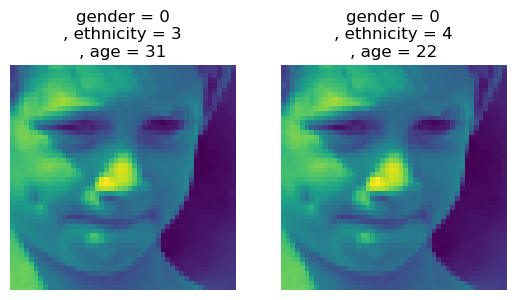

In [153]:
predect_image(2225,model_sss)